# Sieci konwolucyjne

In [4]:
from keras.models import load_model
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from scipy import misc
import math
from tqdm import tqdm
from src.gimp.draw.draw_triangle import draw_triangle as _draw_triangle
from src.gimp.draw.draw_line import draw_line as _draw_line
import os
import time

PREDICTOR = 'model.49-0.87'
RECTANGLE = 'model.11-0.02'
ELLIPSE = 'model.17-0.03'
LINE = 'model.08-0.03'
TRIANGLE = 'model.05-0.04'

class Encoder(object):
    def __init__(self):
        self.shape_predictor = load_model('../result/model/shape_small/{}.hdf5'.format(PREDICTOR))
        self.representation_predictors = [
            load_model('../result/model/rectangle_small/{}.hdf5'.format(RECTANGLE)),
            load_model('../result/model/ellipse_small/{}.hdf5'.format(ELLIPSE)),
            load_model('../result/model/line_small/{}.hdf5'.format(LINE)),
            load_model('../result/model/triangle_small/{}.hdf5'.format(TRIANGLE))
        ]
    
    def encode(self, img):
        start = time.time()
        action = np.argmax(self.shape_predictor.predict(img.reshape([1, 28, 28, 3]))[0])
        args = self.representation_predictors[action].predict(img.reshape([1, 28, 28, 3]))[0]
        end = time.time()
        print('compressed in {} sec'.format(end - start))
        return action, args
    
    
class Decoder(object):
    def __init__(self):
        pass
    
    def decode(self, encoded, size=100):
        start = time.time()
        action, args = encoded
        if action == 0:
            self.draw_ellipse(args, size)
        elif action == 1:
            self.draw_rectangle(args, size)
        elif action == 2:
            self.draw_line(args, size)
        else:
            self.draw_triangle(args, size)
        end = time.time()
        print('decompressed in {} sec'.format(end - start))
            
    def draw(self, y_, shape, size):
        path_to_image_results = '../result/gimp_images/nn/shapes'
        name = 'jupyter_test.png'
        os.system('python ../src/gimp/draw/draw_selection_shape.py --name {} --shape {} --size {} --r {} --g {} --b {} --a {} --x {} --y {} --w {} --h {} --rotation {}'\
                  .format(name, shape, size, y_[0], y_[1], y_[2], y_[3], y_[4], y_[5], y_[6], y_[7], y_[8]))
        image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
        plt.imshow(image_data)

    def draw_rectangle(self, y, size):
        self.draw(y, 'rectangle', size)

    def draw_ellipse(self, y, size):
        self.draw(y, 'ellipse', size)

    def draw_triangle(self, y, size):
        path_to_image_results = '../result/gimp_images/nn/shapes'
        name = 'jupyter_test.png'
        _draw_triangle(name, size, y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9])
        image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
        plt.imshow(image_data)

    def draw_line(self, y, size):
        path_to_image_results = '../result/gimp_images/nn/shapes'
        name = 'jupyter_test.png'
        _draw_line(name, size, y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8])
        image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
        plt.imshow(image_data)
            
    
    
def load_data(name):
    path = "../data/dataset/shape_small/"
    X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
    Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")
    return X, Y

def show_source(i):
    plt.imshow(np.ones(X[i].shape) + X[i])

Using TensorFlow backend.


In [129]:
encoder = Encoder()
decoder = Decoder()

In [72]:
X, _ = load_data('test')

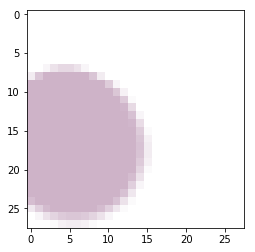

In [139]:
index = np.random.randint(0, X.shape[0])
show_source(index)

In [140]:
encoded = encoder.encode(X[index])
print(encoded)

compressed in 0.9737961292266846 secodns
(2, array([0.50772256, 0.29124847, 0.51851577, 0.46048453, 0.18481405,
       0.5772818 , 0.21570116, 0.6043281 , 0.53597105], dtype=float32))


decompressed in 2.5924344062805176 secodns


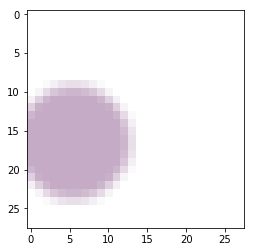

In [141]:
decoder.decode(encoded, size=28)

**obrazek wejściowy ~ 2352 bitów** (obrazek 28 x 28)   
**obrazek zakodowany ~ 41 bitów** (4 bity z numerem akcji + średnio  37 bitów wektora argumentów)   
**compression ratio ~ 57,36** (dla jednej akcji) - czyli dla obrazka 28 x 28 ma to sens dla maksymalnie 57 akcji (można poprawić dodatkowo kompresując ciąg wektorów). Im większy obrazek, tym więcej akcji można wykonać, jednak ilość potrzebnych akcji do osiągnięcia podobnej precyzji jest proporcjonalna do wielkości.   
**compression speed ~ 2500 b/s** - przetwarzanie przez sieć neuronową   
**decompression speed ~ 1000 b/s** - przetwarzanie w gimpie + zapis obrazka na dysk + ponowne wczytanie obrazka   
**dekompresja do dowolnego rozmiaru**   

# Bez sieci neuronowych

In [50]:
import random
import os


ENCODED_PATH = '/tmp/encoded.npy'
DECODED_PATH = '/tmp/decoded.png'
IMAGES_PATH = '../data/image/scaled_images/'

class Encoder(object):
    def __init__(self):
        pass
    
    def encode(self, img_path, actions, size, render):
        start = time.time()
        os.system('python ../src/gimp/draw/generate_actions.py --output_path {} --image {} --actions {} {} --size {}'
                  .format(ENCODED_PATH, os.path.join(IMAGES_PATH, img_path), actions+1, '--render' if render else '', size))
        action_vectors = np.load(ENCODED_PATH)
        end = time.time()
        print('compressed in {} sec'.format(end - start))
        return action_vectors
    
    
class Decoder(object):
    def __init__(self):
        pass
    
    def decode(self, action_args, size=100):
        start = time.time()
#         np.save(ENCODED_PATH, action_args)
        os.system('python ../src/gimp/draw/draw_from_actions.py --action_args {} --size {} --output_path {}'
                  .format(ENCODED_PATH, size, DECODED_PATH))
        image_data = plt.imread(DECODED_PATH)[:,:,:3]
        plt.imshow(image_data)
        end = time.time()
        print('decompressed in {} sec'.format(end - start))
        

def random_img():
    return random.choice(os.listdir(IMAGES_PATH))

def show_img(img_path):
    image_data = plt.imread(os.path.join(IMAGES_PATH, img_path))[:,:,:3]
    plt.imshow(image_data)


In [51]:
encoder = Encoder()
decoder = Decoder()

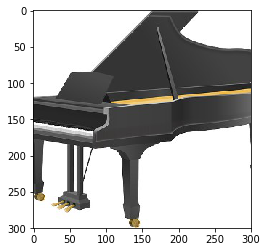

In [52]:
img_path = random_img()
show_img(img_path)

In [57]:
encoded = encoder.encode(img_path, actions=10, size=100, render=True)

compressed in 8.501214265823364 sec


In [58]:
print(encoded)

[[2.         0.69239068 0.56305303 0.48828931 1.         0.60329329
  0.3787227  0.93939209 0.46740626 0.7502511  0.        ]
 [1.         0.97479786 0.96892717 1.         0.75256591 0.63188104
  0.45594239 0.26897911 0.77558479 0.55596637 0.        ]
 [0.         1.         1.         0.98699727 1.         0.73968298
  0.59352812 0.27706623 0.30476095 0.41999886 0.        ]
 [3.         0.59213735 0.43550731 0.472834   0.91848626 0.42173643
  0.02438777 0.         0.56905565 0.88216304 0.58032257]
 [1.         0.11119021 0.20739121 0.24935375 0.75065831 0.57708904
  0.25867717 0.70452158 0.2740828  0.4459483  0.        ]
 [3.         0.57973547 0.61692676 0.61614631 0.91214714 0.50819118
  0.73339168 0.44146251 1.         0.40190234 0.72656679]
 [0.         0.25030891 0.26624806 0.21753467 0.95483462 0.29193326
  0.10173071 0.46767742 0.51792622 0.55561176 0.        ]
 [1.         1.         0.99614312 1.         0.81852735 0.53382291
  0.5512697  0.64898466 0.68537777 0.84065874 0.  

decompressed in 2.7533297538757324 sec


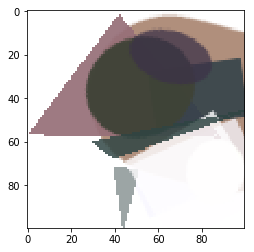

In [59]:
decoder.decode(encoded, size=100)